In [1]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda-forge/openjdk/11.0.1/download/linux-64::openjdk==11.0.1=hacce0ff_1021


The following NEW packages will be INSTALLED:

  openjdk            conda-forge/openjdk/11.0.1/download/linux-64::openjdk-11.0.1-hacce0ff_1021 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
  Using cached pyspark-3.4.0-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sagemaker
from pyspark.sql import functions as f
sess = sagemaker.Session()
bucket = sess.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d0b47657-4fe9-4512-b7ee-3f56686220c8;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 230ms :: artifacts dl 7ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------

3.4.0


## Join External and Comment Data

### Pull and Clean External BTC Data

In [4]:
import pandas as pd

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


btc_in = spark.read.options(header='True', inferSchema='True', delimiter=',').csv("./btc_data_clean.csv")

clean_btc = btc_in.withColumn("prediction_date", f.from_unixtime(f.unix_timestamp(f.col('prediction_date'), 'M/dd/yyy'))) \
                .withColumn('day', f.dayofmonth('prediction_date')) \
                .withColumn('month', f.month('prediction_date')) \
                .withColumn('year', f.year('prediction_date'))

cols_to_keep = ['Volatility','Increase','day','month','year']
selected_cols = [col for col in clean_btc.columns if col in cols_to_keep]
clean_btc_ready = clean_btc.select(selected_cols).toPandas()

### Join with NLP Comment Data

In [5]:
comments_in = pd.read_csv('./NLP_output_for_ml.csv')

In [6]:
full_data = pd.merge(comments_in, clean_btc_ready, left_on = ['day','month','year'], right_on = ['day','month','year']) 

In [7]:
full_data.head()

,Unnamed: 0,year,month,day,total,postotal,negtotal,neutotal,snpcomments,fedcomments,cryptocomments,Volatility,Increase
0,0,2024,3,19,8,6,2,0,0,0,3,0.115697,1
1,1,2023,9,4,24,11,11,2,1,1,6,0.010366,0
2,2,2023,6,29,10,5,5,0,0,0,0,0.051272,1
3,3,2023,8,10,21,14,7,0,0,0,1,0.009294,0
4,4,2023,7,4,6,1,3,2,0,1,0,0.020875,0


## Pipeline in Spark

In [8]:
from pyspark.sql.types import FloatType

#comments_in = spark.read.options(header='True', inferSchema='True', delimiter=',').csv("./NLP_output_for_ml.csv")
full_spark_raw = spark.createDataFrame(full_data).withColumn('Volatility', f.col('Volatility').cast(FloatType()) )


In [9]:
full_spark_raw.show()

+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+
|Unnamed: 0|year|month|day|total|postotal|negtotal|neutotal|snpcomments|fedcomments|cryptocomments| Volatility|Increase|
+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+
|         0|2024|    3| 19|    8|       6|       2|       0|          0|          0|             3| 0.11569654|       1|
|         1|2023|    9|  4|   24|      11|      11|       2|          1|          1|             6|0.010366165|       0|
|         2|2023|    6| 29|   10|       5|       5|       0|          0|          0|             0|0.051271606|       1|
|         3|2023|    8| 10|   21|      14|       7|       0|          0|          0|             1|0.009294065|       0|
|         4|2023|    7|  4|    6|       1|       3|       2|          0|          1|             0|0.020875178|       0|
|         5|2023|    8| 14|   30

In [54]:
full_spark_raw.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- day: long (nullable = true)
 |-- total: long (nullable = true)
 |-- postotal: long (nullable = true)
 |-- negtotal: long (nullable = true)
 |-- neutotal: long (nullable = true)
 |-- snpcomments: long (nullable = true)
 |-- fedcomments: long (nullable = true)
 |-- cryptocomments: long (nullable = true)
 |-- Volatility: float (nullable = true)
 |-- Increase: long (nullable = true)



In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# select only the predictor columns we want in our model
vectorAssembler_features = VectorAssembler(inputCols = ['postotal','negtotal','neutotal','snpcomments','fedcomments','cryptocomments'], outputCol = 'features')
vectorAssembler_volatility = VectorAssembler(inputCols = ['Volatility'], outputCol = 'vol')
#vectorAssembler_increase = VectorAssembler(inputCols = ['Increase'], outputCol = 'inc')

In [11]:
from pyspark.ml.feature import Normalizer

# normalize data 
normalizer = Normalizer(inputCol = 'features', outputCol = 'features_norm')
#normalizerVol = Normalizer(inputCol = 'vol', outputCol = 'vol_norm', p = 1.0)
normalizerInc = Normalizer(inputCol = 'inc', outputCol = 'inc_norm')

In [12]:
from pyspark.ml import Pipeline


pipeline = Pipeline(stages = [vectorAssembler_features, vectorAssembler_volatility, normalizer])
#  vectorAssembler_increase, normalizerVol, normalizerInc
#data_model = pipeline.fit(full_spark_raw)
#pipelined_data = data_model.transform(full_spark_raw)

In [81]:
pipelined_data.show()

+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+--------------------+--------------------+--------------------+
|Unnamed: 0|year|month|day|total|postotal|negtotal|neutotal|snpcomments|fedcomments|cryptocomments| Volatility|Increase|            features|                 vol|       features_norm|
+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+--------------------+--------------------+--------------------+
|         0|2024|    3| 19|    8|       6|       2|       0|          0|          0|             3| 0.11569654|       1|[6.0,2.0,0.0,0.0,...|[0.11569654196500...|[0.85714285714285...|
|         1|2023|    9|  4|   24|      11|      11|       2|          1|          1|             6|0.010366165|       0|[11.0,11.0,2.0,1....|[0.01036616507917...|[0.65272991200661...|
|         2|2023|    6| 29|   10|       5|       5|       0|          0|        

## Building train-test-val datasets

In [13]:
train_data, test_data, val_data = full_spark_raw.randomSplit([0.7, 0.2, 0.1], 42)


In [14]:
print('train size: ', train_data.count()) 
print('test size: ', test_data.count())
print('val size: ', val_data.count())

train size:  290


test size:  98


val size:  36


### Fit pipeline on train data to avoid information leak

In [15]:

pipeline = Pipeline(stages = [vectorAssembler_features, vectorAssembler_volatility,  normalizer])
# normalizerVol, normalizerInc, vectorAssembler_increase,
fitted_pipeline = pipeline.fit(train_data)
train_data = fitted_pipeline.transform(train_data)
test_data = fitted_pipeline.transform(test_data)
val_data = fitted_pipeline.transform(val_data)

In [18]:
val_data.show()

+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+--------------------+--------------------+--------------------+
|Unnamed: 0|year|month|day|total|postotal|negtotal|neutotal|snpcomments|fedcomments|cryptocomments| Volatility|Increase|            features|                 vol|       features_norm|
+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+--------------------+--------------------+--------------------+
|         6|2023|    7|  2|   10|       4|       6|       0|          0|          0|             1|0.025981873|       1|[4.0,6.0,0.0,0.0,...|[0.02598187327384...|[0.54944225579475...|
|         8|2023|    8| 31|   22|      14|       5|       3|          0|          0|             4| 0.03018702|       0|[14.0,5.0,3.0,0.0...|[0.03018702007830...|[0.89260739828867...|
|        47|2023|    6| 22|   10|       4|       6|       0|          0|        

## Build Classification Models (logistic regression, GBT)

#### LR

In [16]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [17]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol='features_norm',labelCol = 'Increase')
lrModel = lr.fit(train_data)


# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))




Coefficients: (6,[],[])
Intercept: 0.1937068790190799


In [18]:
def eval_results_binary(df, model, real = 'Increase', pred = 'prediction'):
    preds = model.transform(df)
    evaluator = MulticlassClassificationEvaluator(labelCol=real, predictionCol=pred, metricName="accuracy")
    accuracy = evaluator.evaluate(preds)

    print("Accuracy = %g" % accuracy)
    print("Train Error = %g" % (1.0 - accuracy))




In [32]:
lr = LogisticRegression(maxIter=10, regParam=0.5, elasticNetParam=0.1, featuresCol='features_norm',labelCol = 'Increase')
lrModel = lr.fit(train_data)

eval_results_binary(train_data, lrModel)
eval_results_binary(test_data, lrModel)

Accuracy = 0.548276
Train Error = 0.451724


Accuracy = 0.438776
Train Error = 0.561224


#### LR with Hyperparameter Search

In [20]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

In [21]:
# fix label column name
train_data_cv = train_data.withColumn('label', f.col('Increase'))

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.3,0.2, 0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# devalre model
lr_cv = LogisticRegression(maxIter=10, regParam=0.5, elasticNetParam=0.1, featuresCol='features_norm',labelCol = 'Increase')

crossval = CrossValidator(estimator=lr_cv,
                      estimatorParamMaps=paramGrid,
                      evaluator=RegressionEvaluator(),
                      numFolds=2)  



"""# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)"""

'# In this case the estimator is simply the linear regression.\n# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.\ntvs = TrainValidationSplit(estimator=lr,\n                           estimatorParamMaps=paramGrid,\n                           evaluator=RegressionEvaluator(),\n                           # 80% of the data will be used for training, 20% for validation.\n                           trainRatio=0.8)'

In [22]:
tuned_lr_model = crossval.fit(train_data_cv)

In [31]:
#tuned_lr_model.explainParam('fitIntercept')
eval_results_binary(train_data, tuned_lr_model.bestModel)
eval_results_binary(test_data, tuned_lr_model.bestModel)

print(tuned_lr_model.bestModel.explainParam('regParam'))
print(tuned_lr_model.bestModel.explainParam('fitIntercept'))
print(tuned_lr_model.bestModel.explainParam('elasticNetParam'))

Accuracy = 0.548276
Train Error = 0.451724


Accuracy = 0.438776
Train Error = 0.561224
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.5)
fitIntercept: whether to fit an intercept term. (default: True)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.1)


best params: reg 0.5, intercept fit = true, elastic net = 0.1.

#### GBT without tuning

In [24]:
gbt = GBTClassifier(labelCol="Increase", featuresCol="features_norm", maxIter=10)
gbt_model = gbt.fit(train_data)



In [25]:
eval_results_binary(train_data, gbt_model)

eval_results_binary(test_data, gbt_model)


Accuracy = 0.827586
Train Error = 0.172414
Accuracy = 0.438776
Train Error = 0.561224


massive overfitting

#### GBT with tuning

In [26]:
test_data_cv = test_data.withColumn('label', f.col('Increase'))


gbt = GBTClassifier(labelCol="Increase", featuresCol="features_norm", maxIter=10)

paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5,4, 3, 2]) \
    .addGrid(gbt.minInstancesPerNode, [1, 2,3])\
    .addGrid(gbt.minInfoGain, [0.0, 0.05, 0.1])\
    .build()


crossval_gbt = CrossValidator(estimator=gbt,
                      estimatorParamMaps=paramGrid_gbt,
                      evaluator=BinaryClassificationEvaluator(),
                      numFolds=2)  


In [48]:
tuned_gbt_model = crossval_gbt.fit(train_data_cv)

In [28]:
eval_results_binary(train_data, gbt_model)
eval_results_binary(test_data, gbt_model)


eval_results_binary(train_data, tuned_gbt_model.bestModel)
eval_results_binary(test_data, tuned_gbt_model.bestModel)

Accuracy = 0.827586
Train Error = 0.172414


Accuracy = 0.438776
Train Error = 0.561224


Accuracy = 0.475862
Train Error = 0.524138


Accuracy = 0.785714
Train Error = 0.214286


In [164]:
print(tuned_gbt_model.bestModel.explainParam('maxDepth'))
print(tuned_gbt_model.bestModel.explainParam('minInstancesPerNode'))
print(tuned_gbt_model.bestModel.explainParam('minInfoGain'))

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30]. (default: 5, current: 5)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1, current: 2)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0, current: 0.0)


best results were depth 5, min instances 2, min info gain 0

### Classification Evaluation Metrics

In [29]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [166]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [169]:
predictions.show()

+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Unnamed: 0|year|month|day|total|postotal|negtotal|neutotal|snpcomments|fedcomments|cryptocomments| Volatility|Increase|            features|                 vol|       features_norm|       rawPrediction|         probability|prediction|
+----------+----+-----+---+-----+--------+--------+--------+-----------+-----------+--------------+-----------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         2|2023|    6| 29|   10|       5|       5|       0|          0|          0|             0|0.051271606|       1| (6,[0,1],[5.0,5.0])|[0.05127160623669...|(6,[0,1],[0.70710...|[0.04072378081366...|[0.52035064163719...|       0.0|
|         9|2023|    7| 22|   23|      12|       8| 

In [30]:
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
#model = gbt_model.fit(train_data)
predictions = gbt_model.transform(test_data)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('prediction','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['prediction'])))
points = CurveMetrics(preds).get_curve('roc')
roc = CurveMetrics(preds).get_curve('roc')


NameError: name 'CurveMetrics' is not defined

In [33]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from pyspark.ml.functions import vector_to_array

predictions = gbt_model.transform(test_data)

y_score = predictions.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true = predictions.select("Increase").rdd.keys().collect()
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

In [34]:

def ROC_curve(model, data):
    preds = model.transform(data)
    
    y_score = preds.select(vector_to_array("probability")[1]).rdd.keys().collect()
    y_true = preds.select("Increase").rdd.keys().collect()
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

In [49]:
fpr_gbt, tpr_gbt, thresholds_gbt, roc_auc_gbt = ROC_curve(gbt_model, test_data)
fpr_gbt_tuned, tpr_gbt_tuned, thresholds_gbt_tuned, roc_auc_gbt_tuned = ROC_curve(tuned_gbt_model.bestModel, val_data)
fpr_lr, tpr_lr, thresholds_lr, roc_auc_lr = ROC_curve(lrModel, test_data)
fpr_lr_tuned, tpr_lr_tuned, thresholds_lr_tuned, roc_auc_lr_tuned = ROC_curve(tuned_lr_model.bestModel, test_data)

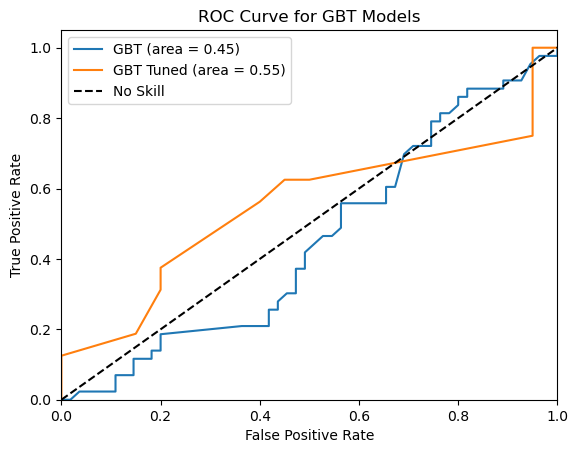

In [50]:
plt.figure()  
plt.plot(fpr_gbt, tpr_gbt, label='GBT (area = %0.2f)' % roc_auc_gbt)
plt.plot(fpr_gbt_tuned, tpr_gbt_tuned, label='GBT Tuned (area = %0.2f)' % roc_auc_gbt_tuned)
#plt.plot(fpr_lr, tpr_lr, thresholds_lr, label='Log Reg. (area = %0.2f)' % roc_auc_lr)
#plt.plot(fpr_lr_tuned, tpr_lr_tuned, label='Log Reg. Tuned (area = %0.2f)' % roc_auc_lr_tuned)

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBT Models')
plt.legend()
plt.show()

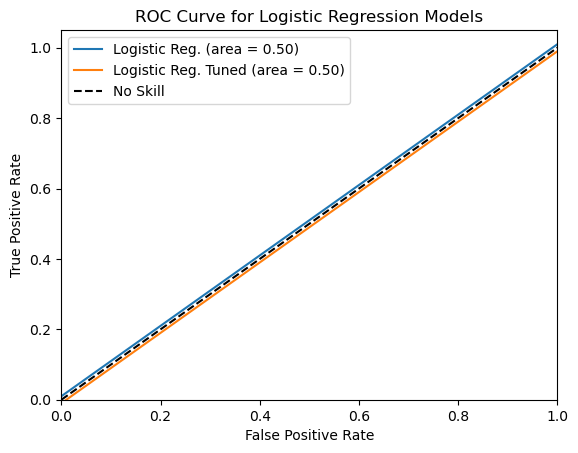

In [44]:
plt.figure()  

plt.plot(fpr_lr, tpr_lr+.01, label='Logistic Reg. (area = %0.2f)' % roc_auc_lr)

plt.plot(fpr_lr_tuned, tpr_lr_tuned-.01, label='Logistic Reg. Tuned (area = %0.2f)' % roc_auc_lr_tuned)

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Models')
plt.legend()
plt.show()

## Build Regression Models

### Linear Regression


In [51]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [52]:
train_data_cv = train_data.withColumn('label', f.col('Increase'))

lr = LinearRegression(featuresCol="features_norm", labelCol="Volatility", predictionCol="predicted_vol", regParam=0.1)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)


In [53]:
def eval_results_reg(model, testdf, labels = 'Volatility', predcol = 'predicted_vol'):

    predictions = model.transform(testdf)
    
    evaluator = RegressionEvaluator(labelCol="Volatility", predictionCol="predicted_vol", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    
    evaluator_r2 = RegressionEvaluator(labelCol="Volatility", predictionCol="predicted_vol", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    print('rmse: ', rmse) 
    print('r2: ', r2)


In [65]:
eval_results_reg(lr_model, train_data)
eval_results_reg(lr_model, test_data)



rmse:  0.02220339615429509
r2:  0.008431300143542875


rmse:  0.02213137254223798
r2:  0.0009947192877705069


#### Tuned Hyperparameters

In [55]:
lr = LinearRegression(featuresCol="features_norm", labelCol="Volatility", predictionCol="predicted_vol")


paramGrid_linreg = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0,0.1,0.2]) \
    .addGrid(lr.elasticNetParam, [0.2, 0.4, 0.6, 0.8])\
    .build()


crossval_linreg = CrossValidator(estimator=lr,
                      estimatorParamMaps=paramGrid_linreg,
                      evaluator=RegressionEvaluator(labelCol="Volatility", predictionCol="predicted_vol", metricName="r2"),
                      numFolds=3)  

In [56]:
tuned_linreg_model = crossval_linreg.fit(train_data)

24/12/07 07:01:43 WARN Instrumentation: [96f402a2] regParam is zero, which might cause numerical instability and overfitting.
24/12/07 07:01:45 WARN Instrumentation: [d4c8098b] regParam is zero, which might cause numerical instability and overfitting.
24/12/07 07:01:45 WARN Instrumentation: [1f98621c] regParam is zero, which might cause numerical instability and overfitting.
24/12/07 07:01:46 WARN Instrumentation: [ce5c9fe2] regParam is zero, which might cause numerical instability and overfitting.
24/12/07 07:01:48 WARN Instrumentation: [0bb4ce86] regParam is zero, which might cause numerical instability and overfitting.
24/12/07 07:01:50 WARN Instrumentation: [cd12cb60] regParam is zero, which might cause numerical instability and overfitting.
24/12/07 07:01:51 WARN Instrumentation: [fa4dbcc2] regParam is zero, which might cause numerical instability and overfitting.
24/12/07 07:01:51 WARN Instrumentation: [f5ee3758] regParam is zero, which might cause numerical instability and overf

In [66]:
eval_results_reg(tuned_linreg_model, train_data)
eval_results_reg(tuned_linreg_model, test_data)

rmse:  0.022297593980785187
r2:  3.3306690738754696e-16


rmse:  0.02216353106124524
r2:  -0.0019106469616598787


In [58]:
print(tuned_linreg_model.bestModel.explainParam('regParam'))
print(tuned_linreg_model.bestModel.explainParam('elasticNetParam'))

regParam: regularization parameter (>= 0). (default: 0.0, current: 0.2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.2)


In [82]:
print(lr_model.coefficients)
print(tuned_linreg_model.bestModel.intercept)

[-0.0006648945929220134,-0.0006146639773429391,-0.000992980630497191,0.006169592546959767,0.000871323960578097,0.002031770773261513]
0.03420036530507536


### Gradient Boosted Regressor

In [60]:
gbr = GBTRegressor(featuresCol="features_norm", labelCol="Volatility", predictionCol="predicted_vol", maxIter=10)

gbr_model = gbr.fit(train_data)

In [67]:
eval_results_reg(gbr_model, train_data)
eval_results_reg(gbr_model, test_data)

rmse:  0.015124025795236173
r2:  0.5399354050685081


rmse:  0.02540514560521019
r2:  -0.31641997320583726


In [62]:
gbr = GBTRegressor(featuresCol="features_norm", labelCol="Volatility", predictionCol="predicted_vol", maxIter=10)


paramGrid_gbr = ParamGridBuilder()\
    .addGrid(gbr.maxDepth, [6, 5,4, 3, 2]) \
    .addGrid(gbr.minInstancesPerNode, [1, 2,3])\
    .addGrid(gbr.minInfoGain, [0.0, 0.05, 0.1])\
    .build()


crossval_gbr = CrossValidator(estimator=gbr,
                      estimatorParamMaps=paramGrid_gbr,
                      evaluator=RegressionEvaluator(labelCol="Volatility", predictionCol="predicted_vol", metricName="r2"),
                      numFolds=2)  

In [63]:
tuned_gbr_model = crossval_gbr.fit(train_data)

In [68]:
eval_results_reg(tuned_gbr_model.bestModel, train_data)
eval_results_reg(tuned_gbr_model.bestModel, test_data)

rmse:  0.022297593980785187
r2:  3.3306690738754696e-16


rmse:  0.02216353106124524
r2:  -0.0019106469616601007


In [79]:
predictions = gbr_model.transform(test_data)
predictions2 = lr_model.transform(test_data)

x_ax = range(0, predictions.count())
y_pred_gbr = predictions.select("predicted_vol").collect()
y_pred_lr = predictions2.select("predicted_vol").collect()

y_orig = predictions.select("Volatility").collect()  

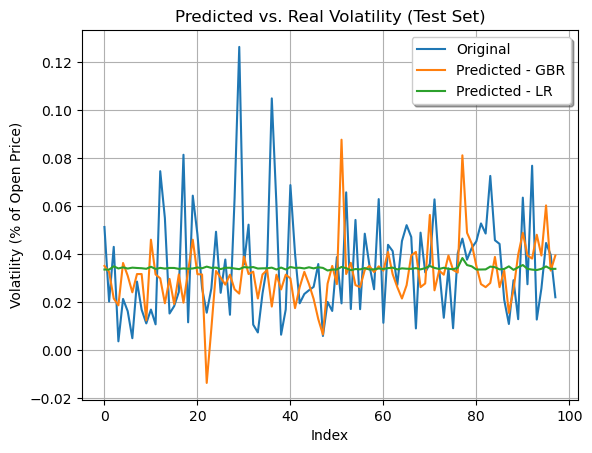

In [81]:
plt.plot(x_ax, y_orig, label="Original")
plt.plot(x_ax, y_pred_gbr, label="Predicted - GBR")
plt.plot(x_ax, y_pred_lr, label="Predicted - LR")

plt.title("Predicted vs. Real Volatility (Test Set)")
plt.xlabel('Index')
plt.ylabel('Volatility (% of Open Price)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()